In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import norm, truncnorm
import time

In [4]:
data_unshuffled = pd.read_csv("SerieA.csv")

In [5]:
data_unshuffled.head()

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2
0,2018-08-18,18:00,Chievo,Juventus,2,3
1,2018-08-18,20:30,Lazio,Napoli,1,2
2,2018-08-19,18:00,Torino,Roma,0,1
3,2018-08-19,20:30,Sassuolo,Inter,1,0
4,2018-08-19,20:30,Parma,Udinese,2,2


0.0458 seconds to run with 10 samples


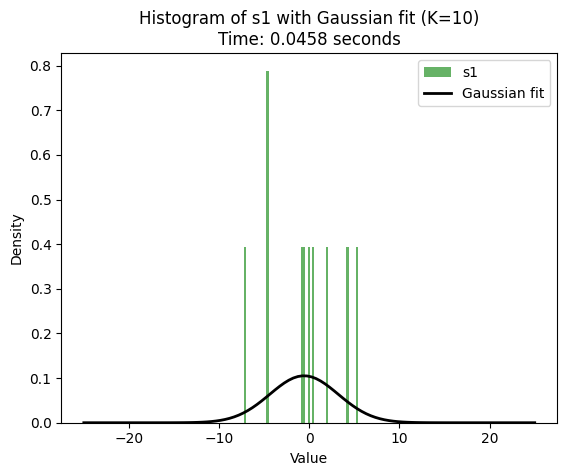

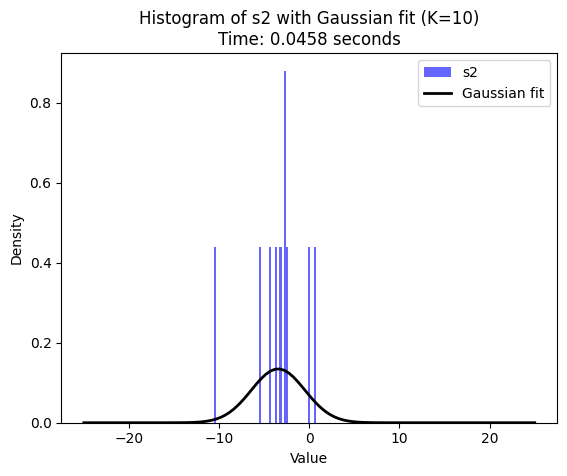

0.0694 seconds to run with 100 samples


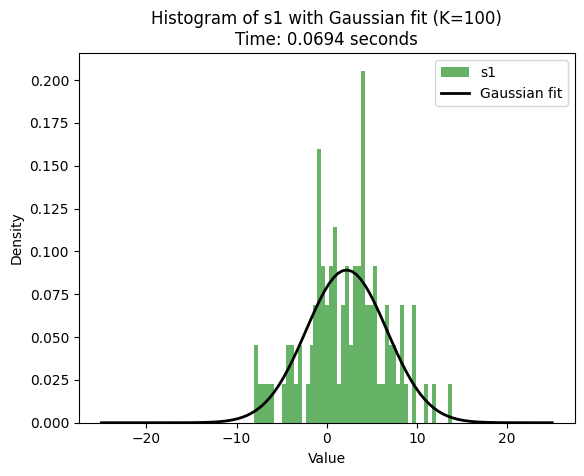

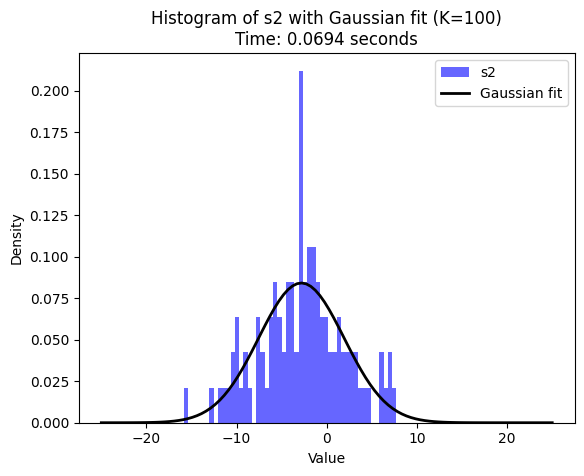

0.7630 seconds to run with 1000 samples


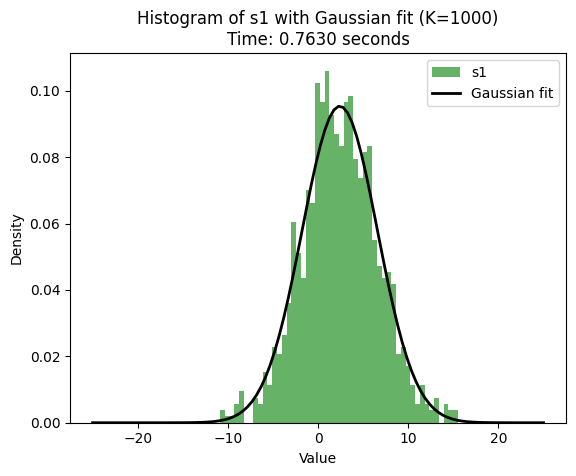

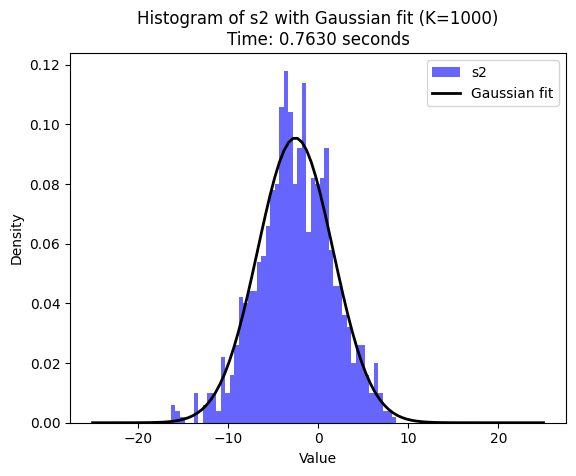

6.8408 seconds to run with 10000 samples


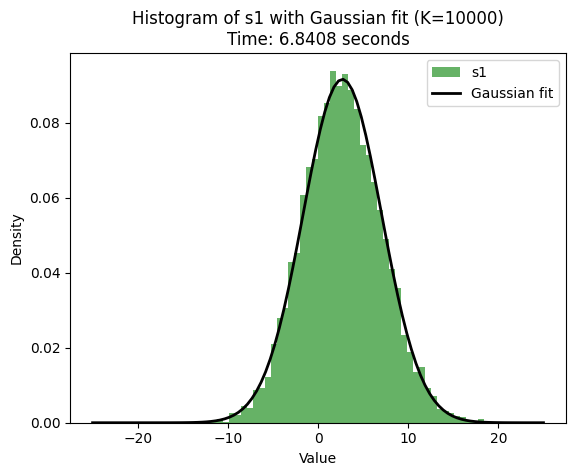

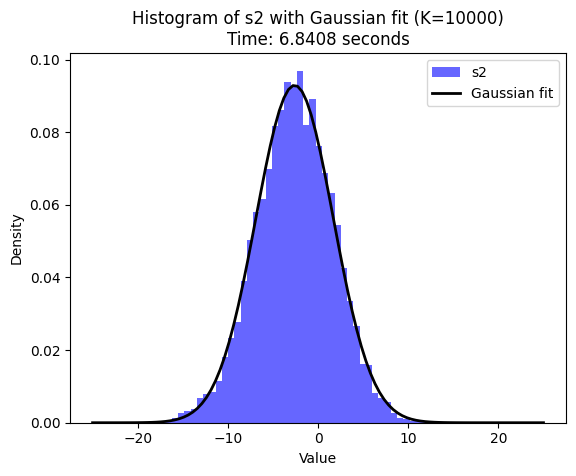

In [2]:
"""
Task 4

"""

def gibbs_sampling(mu1, sigma1, mu2, sigma2, K):
    """
    Perform Gibbs sampling to estimate posterior distributions.

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.
    K: Number of samples.

    Returns:
    s1, s2: Arrays of sampled values.
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    M = np.array([[1, -1]])
    sigma3 = 3

    mu = np.array([[mu1], [mu2]])  # Ensure mu is a column vector
    sigmaA = np.array([[sigma1**2, 0], [0, sigma2**2]])
    sigmaAB = np.linalg.inv(np.linalg.inv(sigmaA) + (1 / sigma3**2) * np.transpose(M) @ M)

    myclip_a = 0
    myclip_b = 1000
    my_std = sigma3

    # Gibbs sampling
    s1 = np.zeros(K)
    s2 = np.zeros(K)
    t = np.zeros(K)
    s1[0] = mu1
    s2[0] = mu2

    for k in range(K-1):
        muAB = sigmaAB @ (np.linalg.inv(sigmaA) @ mu + (1 / sigma3**2) * np.transpose(M) @ np.array([[t[k]]]))
        muAB2 = np.ravel(muAB)  # Flatten the array to 1D
        s1[k+1], s2[k+1] = np.random.multivariate_normal(muAB2, sigmaAB)
        my_mean = s1[k+1] - s2[k+1]
        a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
        t[k+1] = truncnorm.rvs(a, b, loc=my_mean, scale=my_std)

    # Calculate parameters
    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)

    return s1, s2, mu_s1, std_s1, mu_s2, std_s2

def plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed):
    # Parameters for plotting
    x_s1 = np.linspace(mu1 - 5 * sigma1, mu1 + 5 * sigma1, 100)
    x_s2 = np.linspace(mu2 - 5 * sigma2, mu2 + 5 * sigma2, 100)

    mu_s1 = np.mean(s1)
    std_s1 = np.std(s1)
    S1 = norm.pdf(x_s1, mu_s1, std_s1)

    mu_s2 = np.mean(s2)
    std_s2 = np.std(s2)
    S2 = norm.pdf(x_s2, mu_s2, std_s2)

    # Plot s1 histogram and Gaussian fit
    plt.hist(s1, bins=50, density=True, alpha=0.6, color='g', label="s1")
    plt.plot(x_s1, S1, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s1 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    # Plot s2 histogram and Gaussian fit
    plt.hist(s2, bins=50, density=True, alpha=0.6, color='b', label="s2")
    plt.plot(x_s2, S2, 'k', linewidth=2, label="Gaussian fit")
    plt.title(f"Histogram of s2 with Gaussian fit (K={K})\nTime: {time_elapsed:.4f} seconds")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Initial parameters
sigma1, sigma2, sigma3 = 5, 5, 3
mu1, mu2 = 0, 0

# Values of K to test
Ks = [10, 100, 1000, 10000]

for K in Ks:
    time_start = time.perf_counter()
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, K)
    time_elapsed = time.perf_counter() - time_start
    print(f"{time_elapsed:.4f} seconds to run with {K} samples")
    plot_histogram_and_fit(s1, s2, mu1, sigma1, mu2, sigma2, K, time_elapsed)

In [104]:
"""
Task 5

"""


def gibbs_sampling_T5(mu1, sigma1, mu2, sigma2):
    """
    Wrapper function for gibbs_sampling to use a fixed number of samples (5000).

    Parameters:
    mu1, sigma1, mu2, sigma2: Means and standard deviations of the prior distributions.

    Returns:
    mu_s1, std_s1, mu_s2, std_s2: Means and standard deviations of the sampled values.
    """
    K = 1000
    s1, s2, mu_s1, std_s1, mu_s2, std_s2 = gibbs_sampling(mu1, sigma1, mu2, sigma2, K)
    return (mu_s1, std_s1, mu_s2, std_s2)



def update_team_skills(data):
    """
    Update team skills based on match outcomes.

    Parameters:
    data: DataFrame containing match data.

    Returns:
    team_list: Dictionary with updated team skills.
    df: DataFrame with sorted team skills and ranks.
    """
    teams = data['team1'].drop_duplicates()
    team_list = {team: (0, 5) for team in teams}

    for i in range(data.shape[0]):
        print(i)
        score_diff = data.iloc[i]['score1'] - data.iloc[i]['score2']
        if score_diff != 0:
            winner = data.iloc[i]['team1'] if score_diff > 0 else data.iloc[i]['team2']
            loser = data.iloc[i]['team2'] if score_diff > 0 else data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(
                team_list[winner][0], team_list[winner][1],
                team_list[loser][0], team_list[loser][1]
            )
            team_list[winner] = (mu1, sigma1)
            team_list[loser] = (mu2, sigma2)

    df = pd.DataFrame.from_dict(team_list, orient='index', columns=['Skill', 'Standard Deviation'])
    df.sort_values(by='Skill', ascending=False, inplace=True)
    df['Rank'] = range(1, len(df) + 1)

    return team_list, df

# Load data
data_shuffled = pd.read_csv("SerieA.csv").sample(frac=1).reset_index(drop=True)  # Shuffled data
data_unshuffled = pd.read_csv("SerieA.csv")  # Unshuffled data

# Update team skills for shuffled and unshuffled data
team_list_shuffled, df_shuffled = update_team_skills(data_shuffled)
team_list_unshuffled, df_unshuffled = update_team_skills(data_unshuffled)

# Print results
print("Shuffled Data Team List:\n", df_shuffled)
print("\nUnshuffled Data Team List:\n", df_unshuffled)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

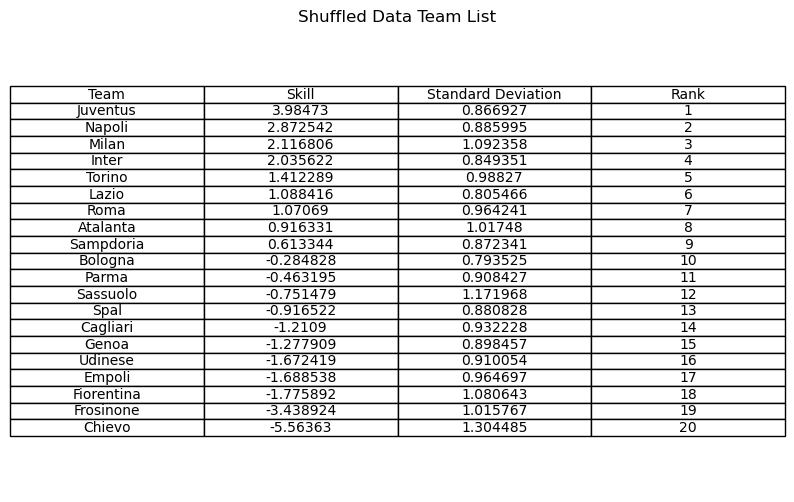

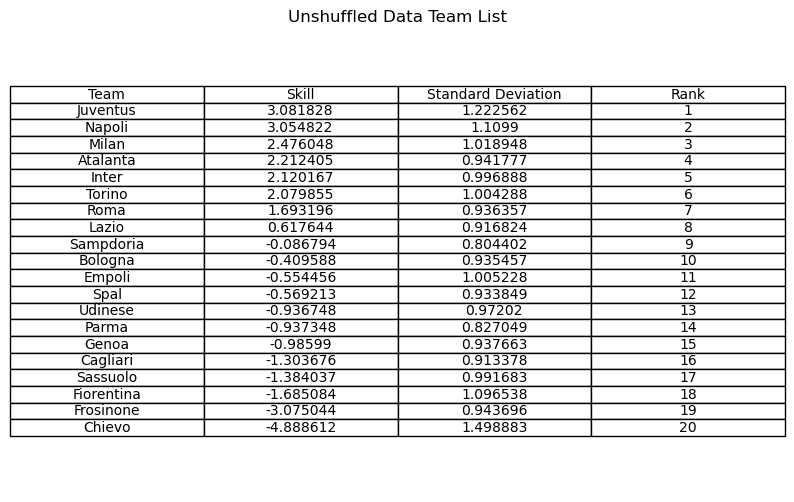

In [25]:
shuffled_data = {
    'Team': ['Juventus', 'Napoli', 'Milan', 'Inter', 'Torino', 'Lazio', 'Roma', 'Atalanta', 'Sampdoria', 'Bologna', 
             'Parma', 'Sassuolo', 'Spal', 'Cagliari', 'Genoa', 'Udinese', 'Empoli', 'Fiorentina', 'Frosinone', 'Chievo'],
    'Skill': [3.984730, 2.872542, 2.116806, 2.035622, 1.412289, 1.088416, 1.070690, 0.916331, 0.613344, -0.284828, 
              -0.463195, -0.751479, -0.916522, -1.210900, -1.277909, -1.672419, -1.688538, -1.775892, -3.438924, -5.563630],
    'Standard Deviation': [0.866927, 0.885995, 1.092358, 0.849351, 0.988270, 0.805466, 0.964241, 1.017480, 0.872341, 0.793525, 
                           0.908427, 1.171968, 0.880828, 0.932228, 0.898457, 0.910054, 0.964697, 1.080643, 1.015767, 1.304485],
    'Rank': list(range(1, 21))
}

# Define data for Unshuffled Data Team List
unshuffled_data = {
    'Team': ['Juventus', 'Napoli', 'Milan', 'Atalanta', 'Inter', 'Torino', 'Roma', 'Lazio', 'Sampdoria', 'Bologna', 
             'Empoli', 'Spal', 'Udinese', 'Parma', 'Genoa', 'Cagliari', 'Sassuolo', 'Fiorentina', 'Frosinone', 'Chievo'],
    'Skill': [3.081828, 3.054822, 2.476048, 2.212405, 2.120167, 2.079855, 1.693196, 0.617644, -0.086794, -0.409588, 
              -0.554456, -0.569213, -0.936748, -0.937348, -0.985990, -1.303676, -1.384037, -1.685084, -3.075044, -4.888612],
    'Standard Deviation': [1.222562, 1.109900, 1.018948, 0.941777, 0.996888, 1.004288, 0.936357, 0.916824, 0.804402, 0.935457, 
                           1.005228, 0.933849, 0.972020, 0.827049, 0.937663, 0.913378, 0.991683, 1.096538, 0.943696, 1.498883],
    'Rank': list(range(1, 21))
}

# Convert data to DataFrames
df_shuffled = pd.DataFrame(shuffled_data)
df_unshuffled = pd.DataFrame(unshuffled_data)

# Plot Shuffled Data Team List
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_shuffled.values, colLabels=df_shuffled.columns, cellLoc='center', loc='center')
plt.title('Shuffled Data Team List')
plt.savefig('shuffled_data_team_list.png', bbox_inches='tight')

# Plot Unshuffled Data Team List
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_unshuffled.values, colLabels=df_unshuffled.columns, cellLoc='center', loc='center')
plt.title('Unshuffled Data Team List')
plt.savefig('unshuffled_data_team_list.png', bbox_inches='tight')

plt.show()

In [28]:
import pandas as pd

# Read the Excel file
players = pd.read_excel('chess_players.xlsx')
print(players.columns)
players = players[17:27]
players = players[['Unnamed: 2', 'Unnamed: 5']]
players = players.rename(columns={'Unnamed: 2': 'player', 'Unnamed: 5': 'ELO'})
# Display the first few rows of the dataframe
players = players.reset_index(drop=True)
print(players)


Index(['From the Tournament-Database of Chess-Results http://chess-results.com',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7'],
      dtype='object')
               player   ELO
0      Keymer Vincent  2672
1     Kollars Dmitrij  2643
2        Svane Rasmus  2640
3  Huschenbeth Niclas  2607
4      Fridman Daniel  2606
5          Braun Arik  2594
6          Engel Luis  2557
7      Svane Frederik  2547
8        Rosner Jonas  2464
9        Kölle Tobias  2433


In [45]:
import pandas as pd

# Read the Excel file
game_results = pd.read_excel('game_results.xlsx')

# Select the required columns
game_results = game_results[['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 7']]

# Select specific row ranges and concatenate them
selected_rows = pd.concat([
    game_results[18:23],  # Rows 18 to 22
    game_results[25:30],  # Rows 25 to 29
    game_results[32:37],  # Rows 32 to 36
    game_results[39:44],  # Rows 39 to 43
    game_results[46:51],  # Rows 46 to 50
    game_results[53:58],  # Rows 53 to 57
    game_results[60:65],  # Rows 60 to 64
    game_results[67:72],  # Rows 67 to 71
    game_results[74:79]   # Rows 74 to 78
])

# Reset the index of the selected rows
selected_rows_reset = selected_rows.reset_index(drop=True)

# Rename the columns
selected_rows_reset = selected_rows_reset.rename(columns={
    'Unnamed: 4': 'team1',
    'Unnamed: 7': 'team2'
})

# Function to calculate points based on 'Unnamed: 5' column values
def assign_points(score):
    if score == '1 - 0':
        return 1, 0  # Player 1 wins
    elif score == '0 - 1':
        return 0, 1  # Player 2 wins
    else:
        return 0.5, 0.5  # Draw, both get 0.5 points
    

# Apply the function to the 'Unnamed: 5' column and create two new columns
selected_rows_reset['score1'], selected_rows_reset['score2'] = zip(*selected_rows_reset['Unnamed: 5'].apply(assign_points))
selected_rows_reset = selected_rows_reset.drop(columns=['Unnamed: 5'])
# Print the final DataFrame with points added
print(selected_rows_reset)


              Player 1            Player 2  Player 1 Points  Player 2 Points
0         Kölle Tobias      Keymer Vincent              0.0              1.0
1           Engel Luis        Rosner Jonas              1.0              0.0
2       Fridman Daniel        Svane Rasmus              0.5              0.5
3      Kollars Dmitrij  Huschenbeth Niclas              0.0              1.0
4       Svane Frederik          Braun Arik              1.0              0.0
5       Keymer Vincent          Braun Arik              1.0              0.0
6   Huschenbeth Niclas      Svane Frederik              0.0              1.0
7         Svane Rasmus     Kollars Dmitrij              0.5              0.5
8         Rosner Jonas      Fridman Daniel              0.0              1.0
9         Kölle Tobias          Engel Luis              1.0              0.0
10          Engel Luis      Keymer Vincent              0.0              1.0
11      Fridman Daniel        Kölle Tobias              1.0              0.0

In [75]:
game_results = pd.read_excel('chessResultsList (5).xlsx')
game_results = game_results[['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','Unnamed: 9',  'Unnamed: 10','Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']]
game_results = game_results.rename(columns={
    'Unnamed: 3': 'Name',
    'Unnamed: 4': 'Rating',
    'Unnamed: 6': 'Round 1',
    'Unnamed: 7': 'Round 2',
    'Unnamed: 8': 'Round 3',
    'Unnamed: 9': 'Round 4',
    'Unnamed: 10': 'Round 5',
    'Unnamed: 11': 'Round 6',
    'Unnamed: 12': 'Round 7',
    'Unnamed: 13': 'Round 8',
    'Unnamed: 14': 'Round 9',
})

game_results = game_results[18:154]
game_results = game_results.drop(columns=['Unnamed: 5'])

game_results = game_results.reset_index(drop=True)

game_results

,Name,Rating,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9
0,Pranesh M,2475,134b1,72w0,118b1,95w1,42b1,11w1,8b1,13w1,4b1
1,Kucuksari Kaan,2492,83b1,95w1,10b1,20w½,8b0,7w1,11b½,9w1,13b1
2,Meshkovs Nikita,2566,127b0,121w½,102b1,112w1,44b1,46w1,9b½,15w1,14b1
3,Urkedal Frode Olav Olsen,2536,118b1,60w1,56b½,23w1,9b½,8w½,39b1,20w1,1w0
4,Galperin Platon,2530,113w1,33b1,39w½,45b½,15w½,17b½,26w½,31b1,20b1
...,...,...,...,...,...,...,...,...,...,...,...
131,Seo Jung Hyun,2156,27b½,34w0,96b0,102w½,108b0,92w0,125b½,124w-,0
132,Sadekov Maksim,2113,61w0,102b½,66w0,19b0,101w0,107b0,-1,125b0,124w0
133,Tryggestad Andreas Garberg,2276,1w0,109b½,122w0,71b0,92b½,117w0,135w½,126b-,0
134,Mittelberger Peter,2206,60b0,118w0,83b0,91w0,124b1,86w0,134b½,97w0,106b-


In [102]:
import re

# Example string
text = "Score 10 before task, 20 after task"

# Pattern to match numbers before the word "before"

name1 = []
score1 = []
name2 = []
score2 = []
for i in range(1, 10):
    players_processed = []
    for j in range(0, len(game_results)):
        #print(j)
        if game_results.loc[j, 'Name'] not in players_processed and isinstance(game_results.loc[j, f'Round {i}'], str):
            
            if "b1" in game_results.loc[j, f'Round {i}']: 
                name1.append(game_results.loc[j, 'Name'])
                score1.append(1)
                players_processed.append(game_results.loc[j, 'Name'])
                pattern = r'(\d+)b1'
                #print('type', type(game_results.loc[j, f'Round {i}']))
                match = re.findall(pattern, game_results.loc[j, f'Round {i}'])
                #print(match)
                name2.append(game_results.loc[int(match[0])-1, 'Name'])
                score2.append(0)
                players_processed.append(game_results.loc[int(match[0])-1, 'Name'])  

            elif "w1" in game_results.loc[j, f'Round {i}']:    
                name1.append(game_results.loc[j, 'Name'])
                score1.append(1)
                players_processed.append(game_results.loc[j, 'Name'])
                pattern = r'(\d+)w1'
                match = re.findall(pattern, game_results.loc[j, f'Round {i}'])
                #print('match',match)
                name2.append(game_results.loc[int(match[0])-1, 'Name'])
                score2.append(0)
                players_processed.append(game_results.loc[int(match[0])-1, 'Name'])
                

                # Find all matches of the pattern in the string
                


In [108]:
game_scores = pd.DataFrame({
    'team1': name1,
    'score1': score1,
    'team2': name2,
    'score2': score2
})
pd.set_option('display.max_rows', None)
game_scores


,team1,score1,team2,score2
0,Pranesh M,1,Tryggestad Andreas Garberg,0
1,Kucuksari Kaan,1,Shaik Sumer Arsh,0
2,Urkedal Frode Olav Olsen,1,Crevatin Leo,0
3,Galperin Platon,1,Bellon Lopez Juan Manuel,0
4,Gorshtein Ido,1,Schenderowitsch Michael,0
5,Sokolovsky Yahli,1,Acikel Mert,0
6,Raja Rithvik R,1,Wagh Suyog,0
7,Parkhov Yair,1,Torngren Gustav,0
8,Souleidis Georgios,1,Ostlund Joar,0
9,Livaic Leon,1,Kupervaser Erez,0


In [110]:
# Update team skills for shuffled and unshuffled data
def update_team_skills_t9(data):
    """
    Update team skills based on match outcomes.

    Parameters:
    data: DataFrame containing match data.

    Returns:
    team_list: Dictionary with updated team skills.
    df: DataFrame with sorted team skills and ranks.
    """
    teams = game_results['Name']
    team_list = {team: (0, 5) for team in teams}

    for i in range(data.shape[0]):
        print(i)
        score_diff = data.iloc[i]['score1'] - data.iloc[i]['score2']
        if score_diff != 0:
            winner = data.iloc[i]['team1'] if score_diff > 0 else data.iloc[i]['team2']
            loser = data.iloc[i]['team2'] if score_diff > 0 else data.iloc[i]['team1']
            mu1, sigma1, mu2, sigma2 = gibbs_sampling_T5(
                team_list[winner][0], team_list[winner][1],
                team_list[loser][0], team_list[loser][1]
            )
            team_list[winner] = (mu1, sigma1)
            team_list[loser] = (mu2, sigma2)

    df = pd.DataFrame.from_dict(team_list, orient='index', columns=['Skill', 'Standard Deviation'])
    df.sort_values(by='Skill', ascending=False, inplace=True)
    df['Rank'] = range(1, len(df) + 1)

    return team_list, df
team_list_shuffled, df_shuffled = update_team_skills_t9(game_scores)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [106]:
data_shuffled.head()

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2
0,2018-12-08,15:00,Napoli,Frosinone,4,0
1,2018-12-26,15:00,Atalanta,Juventus,2,2
2,2018-12-26,18:00,Spal,Udinese,0,0
3,2018-12-29,15:00,Parma,Roma,0,2
4,2019-05-18,15:00,Udinese,Spal,3,2


In [109]:
game_scores.head()

,team1,score1,team2,score2
0,Pranesh M,1,Tryggestad Andreas Garberg,0
1,Kucuksari Kaan,1,Shaik Sumer Arsh,0
2,Urkedal Frode Olav Olsen,1,Crevatin Leo,0
3,Galperin Platon,1,Bellon Lopez Juan Manuel,0
4,Gorshtein Ido,1,Schenderowitsch Michael,0
